In [ ]:
!pip install pytorch-tabnet
!pip install -U --no-cache-dir gdown --pre

!pip install --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cpu


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.8 MB/s eta 0:00:00
  Attempt

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import defaultdict

from sklearn import model_selection, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.multiclass import unique_labels

# model saving
import pickle 
from joblib import Parallel, delayed
import joblib

# heatmap
import seaborn as sn

from matplotlib import pyplot

# tabnet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier


In [ ]:
!gdown 1BQ_5BnEJfpR0a4K1GJB99RVR2Q63eXIF

Downloading...
From: https://drive.google.com/uc?id=1BQ_5BnEJfpR0a4K1GJB99RVR2Q63eXIF
To: /kaggle/working/tumor_gene_Symbol_dataset.csv
100%|██████████████████████████████████████| 1.38G/1.38G [00:20<00:00, 68.3MB/s]


# data process

In [ ]:
gene_symbol_mapping= pd.read_csv("./tumor_gene_Symbol_dataset.csv", sep=',')
gene_symbol_mapping = gene_symbol_mapping.sort_values(by=['Unnamed: 0'])
gene_symbol_mapping= gene_symbol_mapping.set_index('Unnamed: 0')
gene_symbol_mapping = gene_symbol_mapping[gene_symbol_mapping['cancer type abbreviation'].notna()]

gene_symbol_mapping

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658,GBM,78.0,MALE,WHITE
TCGA-02-0055-01,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658,GBM,62.0,FEMALE,WHITE
TCGA-02-2483-01,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658,GBM,43.0,MALE,ASIAN
TCGA-02-2485-01,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658,GBM,53.0,MALE,BLACK OR AFRICAN AMERICAN
TCGA-04-1331-01,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658,OV,78.0,FEMALE,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CF-02,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,LIHC,64.0,MALE,WHITE
TCGA-ZS-A9CG-01,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,LIHC,55.0,MALE,WHITE
TCGA-ZT-A8OM-01,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,THYM,73.0,FEMALE,WHITE


In [ ]:
cancer_names= gene_symbol_mapping['cancer type abbreviation'].unique()

In [ ]:
gene_symbol_mapping['age_at_initial_pathologic_diagnosis']= gene_symbol_mapping['age_at_initial_pathologic_diagnosis'].astype(str)

d = defaultdict(LabelEncoder)
columns_to_encode = [
    "cancer type abbreviation",
    "age_at_initial_pathologic_diagnosis",
    "gender",
    "race"
]

gene_symbol_mapping.loc[:,columns_to_encode] = gene_symbol_mapping.loc[:,columns_to_encode].apply(lambda x: d[x.name].fit_transform(x.fillna('0')))
gene_symbol_mapping.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9784 entries, TCGA-02-0047-01 to TCGA-ZX-AA5X-01
Columns: 19242 entries, RAB4B to race
dtypes: float64(19238), int64(4)
memory usage: 1.4+ GB


In [ ]:
cancer_nums= gene_symbol_mapping['cancer type abbreviation'].unique()
cancer_name_num_dict = dict(zip(cancer_nums, cancer_names))


In [ ]:
gene_symbol_mapping_dummies = gene_symbol_mapping.copy()
gene_symbol_mapping_dummies = pd.get_dummies(gene_symbol_mapping_dummies)

X = gene_symbol_mapping_dummies.copy()
y = gene_symbol_mapping_dummies['cancer type abbreviation'].copy()

# load the datasets

In [ ]:
!gdown 15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP

Downloading...
From (uriginal): https://drive.google.com/uc?id=15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP
From (redirected): https://drive.google.com/uc?id=15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP&confirm=t&uuid=c499bdff-0ed4-4930-9e96-1bfb0db67c1e
To: /content/data.zip
100% 2.42G/2.42G [00:21<00:00, 110MB/s] 


In [ ]:
# !unzip /content/data.zip
!unzip ./data.zip

Archive:  ./data.zip
  inflating: test_split_1.csv        
  inflating: test_split_2.csv        
  inflating: test_split_3.csv        
  inflating: test_split_4.csv        
  inflating: test_split_5.csv        
  inflating: train_split_1.csv       
  inflating: train_split_2.csv       
  inflating: train_split_3.csv       
  inflating: train_split_4.csv       
  inflating: train_split_5.csv       


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
columns_to_drop = [
    "cancer type abbreviation",
    "age_at_initial_pathologic_diagnosis",
    "gender",
    "race"
]

In [ ]:
MAX_EPOCHS = 200
BATCH_SIZE = 512
VIRTUAL_BATCH_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using {}".format(DEVICE))

Using cuda


In [ ]:
def tabNetClassifier(X_train,y_train,model_name):
  X_train_1,X_valid_1,y_train_1 , y_valid_1  = train_test_split(X_train1,y_train1, test_size=0.2, random_state = 42, stratify=y_train1)
  model= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       device_name = DEVICE,
                      )
  model.fit(
    X_train_1.values,y_train_1.values,
    eval_set=[(X_valid_1.values, y_valid_1.values)],
    eval_metric=['accuracy'],
    max_epochs=150, patience=60,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
  )

  joblib.dump(model, model_name)
  # loaded_model = joblib.load('tabnet_model_1.pkl')

   

  return model  

In [ ]:
def plot_conf_matrix(cm, y_test):
    labels=unique_labels(y_test)
    cancer_names=[]
    for i in labels:
        if i in cancer_name_num_dict.keys():
            cancer_names.append(cancer_name_num_dict[i])
    
    column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
    indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]
    
    table= pd.DataFrame(cm, columns=column, index=indices)
    
    fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

    return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

In [ ]:
def classificationReport(model,X_test,y_test):
  y_pred=model.predict(X_test.values)

  cm=(confusion_matrix(y_test, y_pred))
  plot_conf_matrix(cm,y_test)

  predictions = [round(value) for value in y_pred]
  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))

  # precision tp / (tp + fp)
  # precision = precision_score(y_test, predictions, average=None)
  # print('Precision for every class: %f' % precision.astype(str))
  precision = precision_score(y_test, predictions, average='macro')
  print('Precision for all class: %f' % precision)

  # recall: tp / (tp + fn)
  recall = recall_score(y_test, predictions,average='macro')
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, predictions, average='macro')
  print('F1 score: %f' % f1)

  return accuracy, precision, recall, f1, cm


# 1

In [ ]:
test_split_1= pd.read_csv("./test_split_1.csv", sep=',')
test_split_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658,8,64,1,5
1,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658,8,48,0,5
2,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658,8,29,1,2
3,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658,8,39,1,3
4,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658,19,64,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,4.9878,3.2915,3.6939,-4.0350,10.2184,4.4437,-6.5064,-5.0116,-9.9658,0.1648,...,1.5064,-9.9658,-4.0350,1.5854,4.9132,-9.9658,32,64,1,5
1953,5.5420,2.5213,3.8993,-5.5735,10.2946,4.6600,-9.9658,-4.0350,-2.6349,-0.8339,...,2.1147,-9.9658,-9.9658,-1.6394,5.3548,-9.9658,32,24,1,5
1954,4.9050,1.4441,3.9506,-9.9658,10.2031,5.0282,-9.9658,-3.6259,-2.8262,1.1117,...,2.2513,-9.9658,-6.5064,-0.2845,5.0618,-9.9658,32,23,0,5
1955,5.5305,3.3148,3.4752,-3.1714,10.2961,4.1828,-1.2142,-5.5735,-6.5064,0.1519,...,1.6234,-9.9658,-5.5735,2.0946,4.9778,-9.9658,32,46,1,5


In [ ]:
test_split_1_dummies = test_split_1.copy()
test_split_1_dummies = pd.get_dummies(test_split_1_dummies)

X_test_1 = test_split_1_dummies.drop(columns_to_drop, axis=1).copy()
y_test_1 = test_split_1_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_1= pd.read_csv("./train_split_1.csv", sep=',')
train_split_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.4680,3.5694,4.2126,-2.4659,9.0496,5.3636,0.6608,-0.6873,-2.6349,2.0946,...,1.0151,-3.6259,0.8805,4.2578,4.9308,-9.9658,8,46,1,5
1,5.4787,2.7422,3.7571,-1.8836,9.6983,5.7642,0.1903,-0.3022,-1.3921,1.8604,...,1.7702,-2.6349,0.8408,1.1512,4.2103,-9.9658,8,59,0,3
2,5.6994,3.0481,4.1094,-9.9658,9.9318,5.3155,1.8323,0.4967,-2.2447,1.3109,...,0.4967,-9.9658,-0.2498,3.5111,4.7587,-9.9658,8,39,1,5
3,6.2196,2.4985,3.8551,-3.4580,9.6547,5.2114,-2.3884,-1.8836,-1.5522,1.5366,...,1.9111,-2.6349,0.1124,3.3979,4.4784,-9.9658,8,55,1,5
4,6.0540,2.3760,3.6972,-6.5064,10.0772,4.8783,0.3231,0.7321,-2.5479,1.9527,...,0.2881,-9.9658,-0.1031,4.0926,4.6306,-9.9658,8,52,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7822,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,15,50,1,5
7823,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,15,41,1,5
7824,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,29,59,0,5
7825,5.0631,2.9784,3.5212,-5.5735,9.6838,5.0466,1.3956,-2.1140,-1.4699,0.3231,...,1.4704,-0.1031,-5.5735,2.4386,4.8530,-9.9658,4,38,1,5


In [ ]:
train_split_1_dummies = train_split_1.copy()
train_split_1_dummies = pd.get_dummies(train_split_1_dummies)

X_train_1 = train_split_1_dummies.drop(columns_to_drop, axis=1).copy()
y_train_1 = train_split_1_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train1=X_train_1.copy()
y_train1=y_train_1.copy()

In [ ]:
model_1=tabNetClassifier(X_train1,y_train1,'tabnet_model_1.pkl')

accuracy_1, precision_1, recall_1, f1_1, cm1 = classificationReport(model_1, X_test_1,y_test_1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.84566 | val_0_accuracy: 0.03001 |  0:00:09s
epoch 1  | loss: 3.48475 | val_0_accuracy: 0.01533 |  0:00:14s
epoch 2  | loss: 3.23312 | val_0_accuracy: 0.01533 |  0:00:20s
epoch 3  | loss: 2.82929 | val_0_accuracy: 0.02682 |  0:00:26s
epoch 4  | loss: 2.29322 | val_0_accuracy: 0.04853 |  0:00:32s
epoch 5  | loss: 1.66768 | val_0_accuracy: 0.04023 |  0:00:38s
epoch 6  | loss: 1.23828 | val_0_accuracy: 0.09259 |  0:00:44s
epoch 7  | loss: 0.99443 | val_0_accuracy: 0.10536 |  0:00:50s
epoch 8  | loss: 0.76903 | val_0_accuracy: 0.16603 |  0:00:56s
epoch 9  | loss: 0.60833 | val_0_accuracy: 0.27458 |  0:01:02s
epoch 10 | loss: 0.49327 | val_0_accuracy: 0.41507 |  0:01:08s
epoch 11 | loss: 0.48577 | val_0_accuracy: 0.46232 |  0:01:14s
epoch 12 | loss: 0.43242 | val_0_accuracy: 0.48595 |  0:01:20s
epoch 13 | loss: 0.34777 | val_0_accuracy: 0.62324 |  0:01:26s
epoch 14 | loss: 0.289   | val_0_accuracy: 0.66858 |  0:01:32s
epoch 15 | loss: 0.30118 | val_0_accuracy: 0.75351 |  0

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 2

In [ ]:
test_split_2= pd.read_csv("./test_split_2.csv", sep=',')
test_split_2

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.4680,3.5694,4.2126,-2.4659,9.0496,5.3636,0.6608,-0.6873,-2.6349,2.0946,...,1.0151,-3.6259,0.8805,4.2578,4.9308,-9.9658,8,46,1,5
1,5.4787,2.7422,3.7571,-1.8836,9.6983,5.7642,0.1903,-0.3022,-1.3921,1.8604,...,1.7702,-2.6349,0.8408,1.1512,4.2103,-9.9658,8,59,0,3
2,5.6994,3.0481,4.1094,-9.9658,9.9318,5.3155,1.8323,0.4967,-2.2447,1.3109,...,0.4967,-9.9658,-0.2498,3.5111,4.7587,-9.9658,8,39,1,5
3,6.2196,2.4985,3.8551,-3.4580,9.6547,5.2114,-2.3884,-1.8836,-1.5522,1.5366,...,1.9111,-2.6349,0.1124,3.3979,4.4784,-9.9658,8,55,1,5
4,6.0540,2.3760,3.6972,-6.5064,10.0772,4.8783,0.3231,0.7321,-2.5479,1.9527,...,0.2881,-9.9658,-0.1031,4.0926,4.6306,-9.9658,8,52,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.7469,1.4547,4.4542,-4.2934,10.9842,4.8997,-2.8262,0.7832,-4.0350,1.4911,...,0.8164,-3.6259,0.2881,1.5115,5.9789,-9.9658,29,27,1,5
1953,6.1196,1.5514,3.9194,-3.8160,11.2873,4.3492,1.6420,0.0580,-0.9971,0.1776,...,-0.3752,-5.5735,-4.2934,3.6759,5.3615,-9.9658,29,51,0,5
1954,6.2782,-0.2159,2.4883,-5.5735,12.1155,3.9534,-2.2447,-1.2481,-4.6082,-0.8084,...,-0.9971,-5.0116,-0.5125,3.6301,6.4278,-9.9658,29,29,1,5
1955,6.5600,0.9935,3.5060,-9.9658,11.8054,4.3456,-2.9324,-1.6394,-9.9658,-0.1345,...,-1.1488,-3.4580,0.2522,3.5742,6.2489,-9.9658,29,12,1,5


In [ ]:
test_split_2_dummies = test_split_2.copy()
test_split_2_dummies = pd.get_dummies(test_split_2_dummies)

X_test_2 = test_split_2_dummies.drop(columns_to_drop, axis=1).copy()
y_test_2 = test_split_2_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_2= pd.read_csv("./train_split_2.csv", sep=',')
# train_split_1

In [ ]:
train_split_2_dummies = train_split_2.copy()
train_split_2_dummies = pd.get_dummies(train_split_2_dummies)

X_train_2 = train_split_2_dummies.drop(columns_to_drop, axis=1).copy()
y_train_2 = train_split_2_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train2=X_train_2.copy()
y_train2=y_train_2.copy()

In [ ]:
model_2=tabNetClassifier(X_train2,y_train2,'tabnet_model_2.pkl')

accuracy_2, precision_2, recall_2, f1_2, cm2 = classificationReport(model_2, X_test_2,y_test_2)

# 3

In [ ]:
test_split_3= pd.read_csv("./test_split_3.csv", sep=',')
test_split_3

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.5982,4.1277,4.1261,-6.5064,10.0168,5.6525,-0.3201,-1.1811,-1.3921,1.5950,...,2.1798,-6.5064,1.9034,2.7721,4.6077,-9.9658,8,44,1,5
1,4.6713,3.2450,3.3364,-6.5064,9.3261,5.6372,4.2736,-2.0529,1.0847,1.6558,...,2.4831,-4.0350,1.2875,2.5924,4.6826,-9.9658,8,31,0,5
2,5.7748,4.0593,3.9892,-2.7274,9.2628,4.7645,2.9966,0.6969,-1.1811,1.8363,...,1.0847,-3.6259,-0.1345,1.2636,4.1186,-9.9658,8,49,1,5
3,5.0462,2.1766,3.7836,-3.8160,9.0157,5.3972,0.3907,-0.3940,-0.7834,2.0218,...,1.6920,-2.2447,-0.4921,1.3051,4.7296,-9.9658,8,60,1,5
4,5.2502,3.0092,3.7529,-9.9658,10.4801,5.0206,-0.1031,-1.7322,-2.8262,1.5758,...,-0.2498,-4.6082,0.3115,4.1716,4.0401,-9.9658,8,22,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.6235,1.7141,5.1314,-4.0350,10.5520,4.8954,-0.8863,1.5661,-2.9324,1.7185,...,1.6420,-2.8262,0.7832,2.0638,6.1183,-9.9658,29,53,1,5
1953,4.6770,1.6093,4.5230,-5.5735,10.2727,5.1522,-2.1779,2.3251,-0.6643,1.9968,...,2.2113,-5.0116,-1.6850,1.5415,5.0299,-9.9658,29,58,0,2
1954,5.7115,1.8524,5.2246,-5.5735,10.5343,4.6566,-1.3548,1.8363,-1.1172,2.2753,...,1.9895,-2.4659,1.0222,0.1257,6.1861,-9.9658,29,47,1,5
1955,6.0157,0.5763,3.8279,-9.9658,10.7721,3.9403,-0.9686,-2.5479,-0.6643,0.7058,...,0.6880,-4.6082,-2.1140,2.6325,5.9206,-9.9658,29,3,1,2


In [ ]:
test_split_3_dummies = test_split_3.copy()
test_split_3_dummies = pd.get_dummies(test_split_3_dummies)

X_test_3 = test_split_3_dummies.drop(columns_to_drop, axis=1).copy()
y_test_3 = test_split_3_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_3= pd.read_csv("./train_split_3.csv", sep=',')
# train_split_1

In [ ]:
train_split_3_dummies = train_split_3.copy()
train_split_3_dummies = pd.get_dummies(train_split_3_dummies)

X_train_3 = train_split_3_dummies.drop(columns_to_drop, axis=1).copy()
y_train_3 = train_split_3_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train3=X_train_3.copy()
y_train3=y_train_3.copy()

In [ ]:
model_3=tabNetClassifier(X_train3,y_train3,'tabnet_model_3.pkl')

accuracy_3, precision_3, recall_3, f1_3,cm3 = classificationReport(model_3, X_test_3,y_test_3)

# 4

In [ ]:
test_split_4= pd.read_csv("./test_split_4.csv", sep=',')
test_split_4

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.7138,4.1178,2.9090,-1.7809,9.5309,5.4973,-1.4305,-1.7809,-0.2498,0.6425,...,2.4063,-4.0350,-2.5479,3.4635,4.3541,-9.9658,8,37,1,5
1,4.5318,2.5876,5.2642,-9.9658,9.6668,4.8580,-4.2934,-2.8262,-2.4659,2.2051,...,0.7407,-9.9658,-3.0469,0.9268,5.2499,-9.9658,8,49,0,5
2,4.8324,3.0411,3.7794,-5.5735,9.6898,5.1102,7.4223,-2.4659,1.0573,1.4228,...,2.0395,-1.3921,-1.9379,0.7579,4.7986,-9.9658,8,34,1,5
3,4.9397,2.5561,3.9459,-6.5064,9.4092,5.3958,3.4304,-0.6416,-0.4521,2.1541,...,1.4174,-9.9658,-0.2159,0.7832,4.9855,-9.9658,8,41,0,3
4,5.2502,2.3251,3.8401,-9.9658,10.0487,5.3961,0.8726,-1.7322,-0.0725,2.5338,...,1.8840,-1.2828,1.0983,2.6738,4.1820,-9.9658,8,56,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.4813,2.4252,5.9570,-1.6850,9.9599,4.9251,-0.9406,1.5115,-0.0425,2.2723,...,1.4808,-0.9406,1.0915,1.9931,5.9258,-9.9658,29,32,1,5
1953,4.0567,1.3679,5.4219,0.7664,9.8447,4.7677,-0.5973,3.5299,-3.4580,2.4306,...,2.5900,-4.0350,-2.8262,0.2881,4.9103,-9.9658,29,56,1,5
1954,4.6165,1.6512,5.2032,0.4125,9.9029,4.7285,1.9638,1.7446,-0.2671,1.3956,...,1.7229,-3.8160,-5.5735,-0.7346,4.9458,-9.9658,29,61,0,5
1955,5.6691,1.7660,5.2480,-4.2934,10.7449,3.9270,-0.3940,0.8568,0.6517,1.1770,...,0.8568,-3.6259,-9.9658,2.0912,5.4125,-9.9658,29,64,0,5


In [ ]:
test_split_4_dummies = test_split_4.copy()
test_split_4_dummies = pd.get_dummies(test_split_4_dummies)

X_test_4 = test_split_4_dummies.drop(columns_to_drop, axis=1).copy()
y_test_4 = test_split_4_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_4= pd.read_csv("./train_split_4.csv", sep=',')
# train_split_1

In [ ]:
train_split_4_dummies = train_split_4.copy()
train_split_4_dummies = pd.get_dummies(train_split_4_dummies)

X_train_4 = train_split_4_dummies.drop(columns_to_drop, axis=1).copy()
y_train_4 = train_split_4_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train4=X_train_4.copy()
y_train4=y_train_4.copy()

In [ ]:
model_4=tabNetClassifier(X_train4,y_train4,'tabnet_model_4.pkl')

accuracy_4, precision_4, recall_4, f1_4,cm4 = classificationReport(model_4, X_test_4,y_test_4)

# 5

In [ ]:
test_split_5= pd.read_csv("./test_split_5.csv", sep=',')
test_split_5

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.6759,2.4960,3.4609,-4.6082,9.7135,5.7955,1.3109,1.0293,-3.0469,1.3567,...,1.9490,-3.0469,-3.0469,1.7273,4.9691,-9.9658,8,63,0,5
1,5.8829,3.0252,3.3119,-6.5064,9.4547,5.4900,1.4174,-1.4305,-1.8836,1.8801,...,1.4011,-5.0116,-0.3383,3.7561,5.0184,-9.9658,8,55,0,5
2,5.8199,2.8076,3.9031,-6.5064,9.2346,5.6787,0.6425,-0.3383,-2.3147,3.0110,...,1.4120,-4.6082,2.2330,4.2111,5.2877,-9.9658,8,31,1,2
3,5.3162,4.2758,3.4437,-5.5735,9.8965,5.6303,0.4447,-1.0559,-0.4921,1.9564,...,1.8363,-5.0116,-5.5735,3.4411,5.1148,-9.9658,8,58,1,5
4,5.1339,2.9186,3.5299,-3.6259,9.6870,5.7436,3.0446,1.7446,-0.4131,2.0638,...,1.5013,-3.4580,1.1184,1.9377,4.1555,-9.9658,8,57,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,15,50,1,5
1952,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,15,41,1,5
1953,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,29,59,0,5
1954,5.0631,2.9784,3.5212,-5.5735,9.6838,5.0466,1.3956,-2.1140,-1.4699,0.3231,...,1.4704,-0.1031,-5.5735,2.4386,4.8530,-9.9658,4,38,1,5


In [ ]:
test_split_5_dummies = test_split_5.copy()
test_split_5_dummies = pd.get_dummies(test_split_5_dummies)

X_test_5 = test_split_5_dummies.drop(columns_to_drop, axis=1).copy()
y_test_5 = test_split_5_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_5= pd.read_csv("./train_split_5.csv", sep=',')
# train_split_1

In [ ]:
train_split_5_dummies = train_split_5.copy()
train_split_5_dummies = pd.get_dummies(train_split_5_dummies)

X_train_5 = train_split_5_dummies.drop(columns_to_drop, axis=1).copy()
y_train_5 = train_split_5_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train5=X_train_5.copy()
y_train5=y_train_5.copy()

In [ ]:
model_5=tabNetClassifier(X_train5,y_train5,'tabnet_model_5.pkl')

accuracy_5, precision_5, recall_5, f1_5,cm5 = classificationReport(model_5, X_test_5,y_test_5)

# avg accuracy

In [ ]:
avg_acc=(accuracy_1+accuracy_2+accuracy_3+accuracy_4+accuracy_5)/5
avg_acc

0.9553349467539837

In [ ]:
avg_precision=(precision_1+precision_2+precision_3+precision_4+precision_5)/5
avg_precision

In [ ]:
avg_recall=(recall_1+recall_2+recall_3+recall_4+recall_5)/5
avg_recall

In [ ]:
avg_f1=(f1_1+f1_2+f1_3+f1_4+f1_5)/5
avg_f1

In [ ]:
cm=cm1+cm2+cm3+cm4+cm5

In [ ]:
def plot_final_conf_matrix():
    labels=y_test_5.unique()
    cancer_names=[]
    for i in labels:
        if i in cancer_name_num_dict.keys():
            cancer_names.append(cancer_name_num_dict[i])
    
    column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
    indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]
    
    table= pd.DataFrame(cm, columns=column, index=indices)
    
    fig, ax = pyplot.subplots(figsize=(20,20))         # Sample figsize in inches

    return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

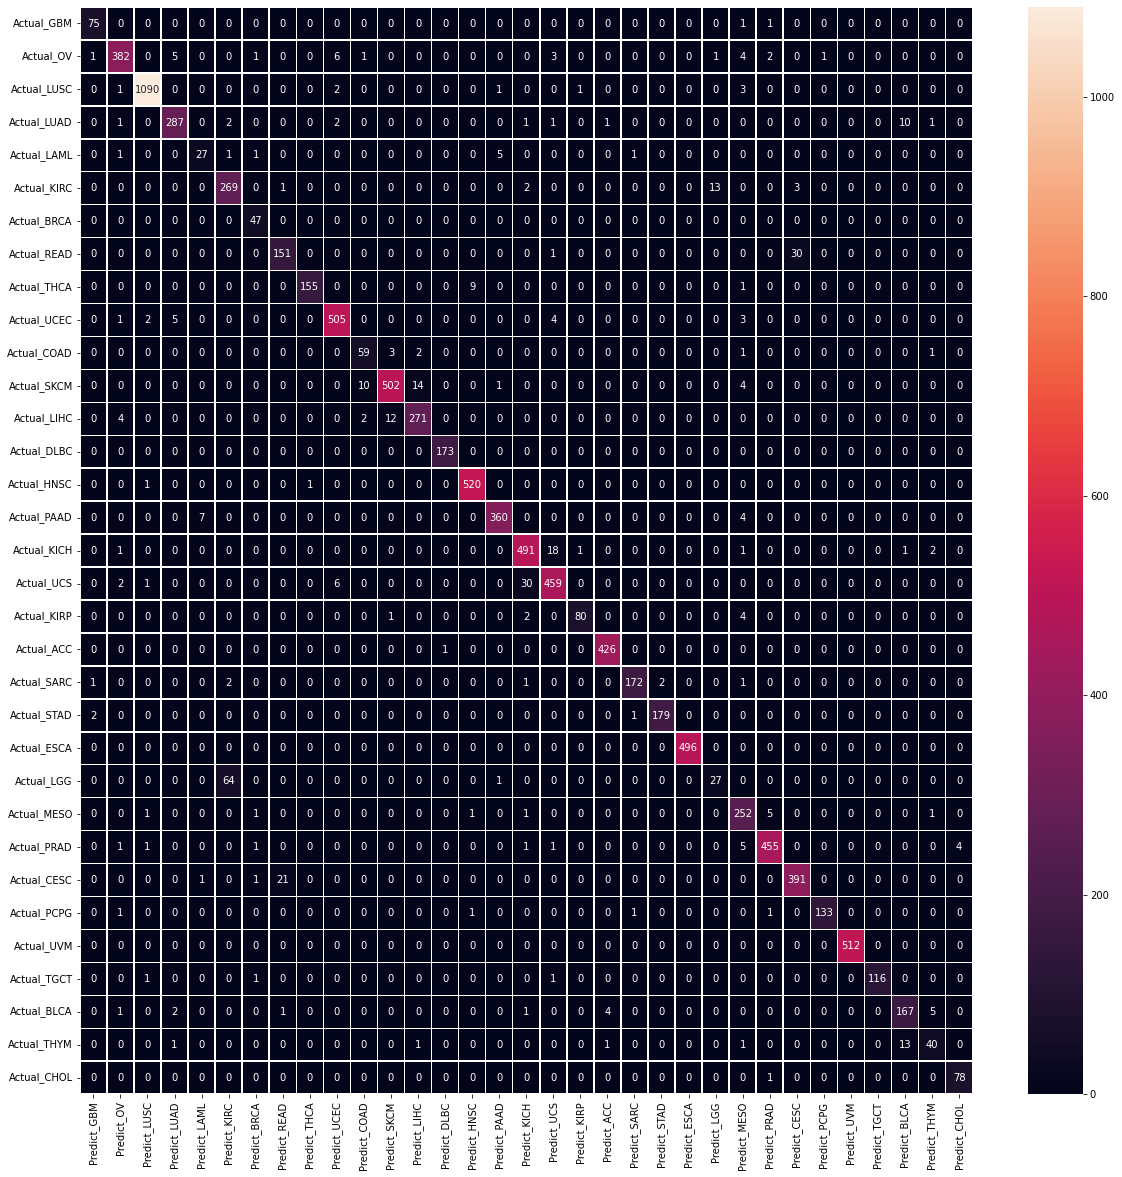

In [ ]:
plot_final_conf_matrix()